# Group kfold linear regression by habitat

## 1. Load packages and custom functions

In [119]:
# -*- coding: utf-8 -*-
"""
Updated 20 January 2025

"""

from IPython import get_ipython
print(__doc__)

# Clear all the variables
get_ipython().run_line_magic('reset', '-sf')

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")
# from pathlib import Path 
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path 
import os
import sys
import numpy as np
from numpy import mean
import statsmodels.api as sm
import scipy.stats as stats

import seaborn as sns

# scikit-learn (machine learning) package
from sklearn.preprocessing import (StandardScaler)
from sklearn.linear_model import  HuberRegressor

from sklearn.model_selection import RepeatedKFold, permutation_test_score, GroupKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Close all the figures (like in Matlab)
plt.close("all")

# Import configuration file
sys.path.append(str(Path('../src')))
import config as cfg


Updated 20 January 2025




#### Custom functions

In [120]:
def groupkfold_regression (
                indices, 
                gt, 
                df, 
                model,
                seed = 1979, 
                verbose=False) :
        """
        Perform a GroupKFold cross-validation on a regression model.

        Parameters
        ----------
        indices : list
            List of indices to use as predictors.
        gt : str
            Name of the column containing the ground truth.
        df : pandas.DataFrame
            Dataframe containing the data.
        model : sklearn.linear_model
            Model to use for the regression.
        seed : int, optional
            Seed for the random number generator. The default is 1979.
        verbose : bool, optional
            Print the results. The default is False.
        
        Returns
        -------
        df_metrics_kfold : pandas.DataFrame
            Dataframe containing the metrics.
        models_list : list
            List of the best models.
        
        """

        # initialize the dataframe to store the metrics
        df_metrics_kfold = pd.DataFrame(columns=[
                                        'INDICE', 
                                        'CCC', 'CCC_L_SHIFT','CCC_S_SHIFT', 'CCC_BIAS', 'ME', 'MAE', 'RMSE', 'R2', 'MEDIAN_AE', 'pvalue']) 
        
        # empty dictionnary to store the best model for each indice
        models_list = []
        
        # concatenate the list CONFIG['list_indices'] to a string
        INDICE_STR = '_'.join(indices)

        # set a number to each habitat in order to have a unique group for each habitat
        groups = df['habitat'].astype('category').cat.codes
        if verbose : print(f'The groups are {groups.unique()}')  

        # 1. Set the data
        if len(indices) == 1 :
            X_kfold = df[indices].to_numpy().reshape(-1,1)
        else :
            X_kfold = df[indices].to_numpy()
        
        y_kfold = df[gt].to_numpy()

        # 2. Create the kfold cross-validation 
        cv = GroupKFold(n_splits=groups.nunique())

        # 3. Train and test model with repeated cross-validation
        scoring = {
                'MAE': 'neg_mean_absolute_error',
                'MEDIAN_AE': 'neg_median_absolute_error',
                'RMSE': 'neg_root_mean_squared_error',
                'ME': make_scorer(mean_error),
                'CCC': make_scorer(ccc_est),
                'CCC_L_SHIFT': make_scorer(ccc_l_shift),
                'CCC_S_SHIFT': make_scorer(ccc_s_shift),
                'CCC_BIAS': make_scorer(ccc_bias),
                'R2': 'r2'
                }
        
        # BUG cross_validate does not take CV but rather use the default parameter which is n_splits=5        
        scores = cross_validate(model, 
                                X_kfold, 
                                y_kfold, 
                                scoring=scoring, 
                                cv=cv, 
                                n_jobs=-1, 
                                return_train_score=True, 
                                return_estimator=True,
                                groups=groups)

        # Evaluate the significance of a cross-validated score with permutations.
        # Permutes targets to generate ‘randomized data’ and compute the empirical p-value 
        # against the null hypothesis that features and targets are independent.
        _, _, pvalue = permutation_test_score(
                                model, 
                                X_kfold, 
                                y_kfold, 
                                cv=cv, 
                                n_jobs=-1, 
                                n_permutations=100, 
                                random_state=seed,
                                groups=groups)

        # 5. Metrics
        CCC         = mean(scores['test_CCC'])
        CCC_L_SHIFT = mean(scores['test_CCC_L_SHIFT'])
        CCC_S_SHIFT = mean(scores['test_CCC_S_SHIFT'])
        CCC_BIAS    = mean(scores['test_CCC_BIAS'])
        RMSE        = abs(mean(scores['test_RMSE']))
        ME          = abs(mean(scores['test_ME']))   
        MAE         = abs(mean(scores['test_MAE']))
        R2          = mean(scores['test_R2'])
        MEDIAN_AE   = abs(mean(scores['test_MEDIAN_AE']))
        PVALUE      = pvalue
        if verbose :
                print('CCC={} CCC_L_SHIFT={} CCC_S_SHIFT={} CCC_BIAS={} ME{} MAE={} RMSE={} R2={} MEDIAN_AE={} P-value={}'.format(
                                                                round(CCC,2),
                                                                round(CCC_L_SHIFT,2),
                                                                round(CCC_S_SHIFT,2),
                                                                round(CCC_BIAS,2), 
                                                                round(ME,2),
                                                                round(MAE,2), 
                                                                round(RMSE,2), 
                                                                round(R2,2),
                                                                round(MEDIAN_AE,2),
                                                                PVALUE))

        # #############################################
        # # Test on datasets that was never seen before
        # #############################################

        # 6. select the best model (median of the scores)
        best_model = scores['estimator'][scores['test_CCC'].argmax()]
        
        # store the best model in a dictionnary corresponding to the current indice
        models_list.append({INDICE_STR: best_model})        

        # 11. Store the scores in a dataframe
        # add the metrics to the dataframe df_metrics
        m = pd.DataFrame.from_dict({
                        'INDICE': [INDICE_STR],
                        'CCC': [CCC],
                        'CCC_L_SHIFT': [CCC_L_SHIFT],
                        'CCC_S_SHIFT': [CCC_S_SHIFT],
                        'CCC_BIAS': [CCC_BIAS],
                        'ME': [ME],
                        'MAE': [MAE],
                        'RMSE': [RMSE],
                        'R2': [R2],
                        'MEDIAN_AE': [MEDIAN_AE],
                        'pvalue': [PVALUE],
                })
        
        df_metrics_kfold = pd.concat([df_metrics_kfold, m], axis=0, ignore_index=True)

        return df_metrics_kfold, models_list

def plot_datasets (
                y_true, 
                y_pred, 
                metric=None, 
                xlabel="Observation",    
                ylabel="Prediction",
                color=None,
                plot_qqplot=False, 
                plot_residuals=False, 
                plot_residuals_distribution=False):

    """
    Plot the results of a regression model.

    Parameters
    ----------
    y_true : numpy.array
        Observed values.
    y_pred : numpy.array
        Predicted values.
    metric : integer, optional
        Metric to show on the scatter plot. The default is None.
    xlabel : str, optional
        Name of the xlabel. The default is "Species Richness Observed".
    ylabel : str, optional
        Name of the ylabel. The default is None.
    plot_qqplot : bool, optional
        Plot the QQ plot. The default is False.
    plot_residuals : bool, optional
        Plot the residuals. The default is False.
    plot_residuals_distribution : bool, optional
        Plot the residuals distribution. The default is False.
    
    Returns
    -------
    plt
        Plot.
    
    """
    #############################################
    # PLOT observation (y_obs) vs prediction (y_pred)
    #############################################
    fig, ax1 = plt.subplots(1, 1, sharey=True, sharex=True)
    fig.set_size_inches(4,4)
    fig.tight_layout()
    # plot scatter plot
    ax1.scatter(y_true, y_pred, alpha=0.5, color=color)
    ax1.grid()
    # plot the line y=x
    ax1.plot([0, y_true.max()], [0, y_true.max()], 'k--', lw=1)
    # add metric on the plot
    ax1.annotate(
            "%s = %.2f" % (get_var_name(metric), metric), 
            xy=(0.7, 0.05), 
            xycoords='axes fraction', 
            fontsize = 8,
            bbox=dict(
                    facecolor='lightgrey', 
                    alpha = 0.33,
                    edgecolor='white', 
                    boxstyle='round')
            )
    # add x and y labels
    fig.text(0.5, 0, xlabel , ha='center')
    fig.text(0, 0.5, ylabel , va='center', rotation='vertical')
        
    #############################################
    # QQ PLOT
    #############################################
    if plot_qqplot:
        fig, ax3= plt.subplots(1, 1, sharey=True, sharex=True)
        fig.set_size_inches(4,4)
        fig.tight_layout()    
        sm.qqplot(y_true-y_pred, stats.t,  fit=True, alpha=0.25, ax=ax3, markerfacecolor=color, markeredgecolor=color)
        # add the line y=x
        sm.qqline(ax3, line='45', color='k', linewidth=1, linestyle='dashed')
        # add grid
        ax3.grid()

    #############################################       
    # RESIDUALS vs PREDICTION
    ############################################# 
    if plot_residuals:
        fig, ax7 = plt.subplots(1, 1, sharey=True, sharex=True)
        fig.set_size_inches(4,4)
        fig.tight_layout()
        # plot the residuals vs the prediction
        ax7.scatter(y_pred, y_true-y_pred, alpha=0.5, color=color)
        # add the line y=0
        ax7.axhline(y=0, color='k', linestyle='--', linewidth=1)
        # add grid
        ax7.grid()
        # add x and y labels
        fig.text(0.5, 0, "Predicted Values" , ha='center')
        fig.text(0, 0.5, "Residual (Observed - Predicted)", va='center', rotation='vertical')

    #############################################       
    # RESIDUALS DISTRIBUTION
    #############################################
    if plot_residuals_distribution:
        fig, ax5 = plt.subplots(1, 1, sharey=True, sharex=True)
        fig.set_size_inches(4,4)
        fig.tight_layout()
        # plot a histogram of the residuals on axis ax3
        ax5.hist(y_true-y_pred, bins=25, color=color)
        # add grid
        ax5.grid()
        # add x and y labels
        fig.text(0.5, 0, "Residual (Observed - Predicted)" , ha='center')
        fig.text(0, 0.5, "Count", va='center', rotation='vertical')

    return plt

def plot_pi_ci_manual(t, std_error, n, x, x2, y2, ci=True, pi=True, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
        http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    -- from https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot

    """
    if ax is None:
        ax = plt.gca()

    # Confidence Interval (CI)
    if ci:
        ci = t * std_error * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        ax.fill_between(x2, y2 + ci, y2 - ci, color="0.25", edgecolor=None, alpha=0.33)

        
    # Prediction Interval (PI)
    if pi:
        pi = t * std_error * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
        ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--", linewidth=1)
        ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits", linewidth=1)
        ax.plot(x2, y2 + pi, "--", color="0.5", linewidth=1)

    return ax, ci, pi

def epi_ccc(x, y, ci="z-transform", conf_level=0.95):
    """
    Calculate the concordance correlation coefficient (CCC) and associated statistics.

    -- Source: https://rdrr.io/cran/epiR/man/epi.ccc.html 
    -- Reference: Lawrence, I., & Lin, K. (1989). A concordance correlation coefficient to evaluate reproducibility. habitattrics, 255–268.

    Parameters
    ----------
    x : array-like
        First set of measurements.
    y : array-like
        Second set of measurements.
    ci : str, optional
        Method for confidence interval calculation. Options are "z-transform" (default) or "asymptotic".
    conf_level : float, optional
        Confidence level for the interval. Default is 0.95.
    Returns
    -------
    dict
        A dictionary containing the following keys:
        - "rho_c": dict with keys "est", "lower", and "upper" representing the estimated CCC and its confidence interval.
        - "s_shift": Scale shift.
        - "l_shift": Location shift relative to the scale.
        - "C_b": Bias correction factor.
        - "blalt": Bland-Altman statistics.
        - "nmissing": Number of missing values removed from the input data.
    The function removes any missing values from the input data before performing calculations.
    """

    N = 1 - ((1 - conf_level) / 2)
    zv = stats.norm.ppf(N)

    x = np.array(x)
    y = np.array(y)

    # Remove missing values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    nmissing = np.sum(~mask)

    k = len(y)
    yb = np.mean(y)
    sy2 = np.var(y, ddof=1) * (k - 1) / k
    sd1 = np.std(y, ddof=1)

    xb = np.mean(x)
    sx2 = np.var(x, ddof=1) * (k - 1) / k
    sd2 = np.std(x, ddof=1)

    r = np.corrcoef(x, y)[0, 1]
    sl = r * sd1 / sd2

    sxy = r * np.sqrt(sx2 * sy2)
    p = 2 * sxy / (sx2 + sy2 + (yb - xb)**2)

    # Bland-Altman:
    delta = x - y
    rmean = np.mean([x, y], axis=0)
    blalt = np.vstack((rmean, delta)).T

    # Scale shift:
    v = sd1 / sd2
    # Location shift relative to the scale:
    u = (yb - xb) / ((sx2 * sy2) ** 0.25)

    # Bias correction factor:
    C_b = p / r

    # Standard error and CI for asymptotic normal approximation:
    sep = np.sqrt(((1 - r**2) * p**2 * (1 - p**2) / r**2 + (2 * p**3 * (1 - p) * u**2 / r) - 0.5 * p**4 * u**4 / r**2) / (k - 2))
    ll = p - (zv * sep)
    ul = p + (zv * sep)

    # Statistic and CI for inverse hyperbolic tangent transform:
    t = np.log((1 + p) / (1 - p)) / 2
    set = sep / (1 - p**2)
    llt = t - (zv * set)
    ult = t + (zv * set)
    llt = (np.exp(2 * llt) - 1) / (np.exp(2 * llt) + 1)
    ult = (np.exp(2 * ult) - 1) / (np.exp(2 * ult) + 1)

    # Concordance correlation coefficient results:
    if ci == "asymptotic":
        rho_c = {"est": p, "lower": ll, "upper": ul}
    elif ci == "z-transform":
        rho_c = {"est": p, "lower": llt, "upper": ult}

    return {
        "rho_c": rho_c,
        "s_shift": v,
        "l_shift": u,
        "C_b": C_b,
        "blalt": blalt,
        "nmissing": nmissing
    }

def ccc_est(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['rho_c']['est']

def ccc_lower(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['rho_c']['lower']

def ccc_upper(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['rho_c']['upper']

def ccc_s_shift(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['s_shift']

def ccc_l_shift(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['l_shift']

def ccc_bias(x, y) :
    ccc_summary = epi_ccc(x, y)
    return ccc_summary['C_b']

def mean_error(x, y) :
    return np.mean(x - y)

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

## 2. Notebook init and options setting

* Select the csv file corresponding to the aggregations that we want to analyze (by site, by day and site)

In [ ]:
"""****************************************************************************
# -------------------          options              ---------------------------
****************************************************************************"""
SAVE = False
PROCESS = True
DISPLAY = True
VERBOSE = False

# Load the configuration file
CONFIG = cfg.load_config('config_publication.yaml')

# set the ground truth
GT = CONFIG['ground_truth']

PALETTE_NAME = "Set2" # Set1 Set2 Set3 husl colorblind tab20
NUM_COLORS = 8

# set a dictionnary with the color for each habitat
HABITAT_COLOR = {
       'Arable land': sns.color_palette(PALETTE_NAME, NUM_COLORS)[0],
       'Forest - Subtropical-tropical moist lowland': sns.color_palette(PALETTE_NAME, NUM_COLORS)[1],
       'Forest - Subtropical-tropical moist montane': sns.color_palette(PALETTE_NAME, NUM_COLORS)[2],
       'Plantations': sns.color_palette(PALETTE_NAME, NUM_COLORS)[3],
       'Forest - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[4],
       'Shrubland - Subtropical-tropical high altitude': sns.color_palette(PALETTE_NAME, NUM_COLORS)[5],
       'Shrubland - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[6],
       }

# Get the default palette
RED     = sns.color_palette('Set1')[0]
BLUE    = sns.color_palette('Set1')[1]
GREEN   = sns.color_palette('Set1')[2]

# Set the csv file corresponding to the aggregations
# csv_filename = 'species_richness_by_site_and_day_sans_clip.csv'
csv_filename = 'species_richness_by_site_sans_clip.csv'
# csv_filename = 'species_richness_mean_by_time_month_1h_by_site_sans_clip.csv'
# csv_filename = 'species_richness_mean_by_time_week_15min_by_site_sans_clip.csv'

## 3. Preparation of the dataframe df



### 3.1 Read and prepare the dataframe with the aggregated samples


The number of aggregated samples is 118
The number of sites after removing the habitats with less than 5 aggregated samples is 117


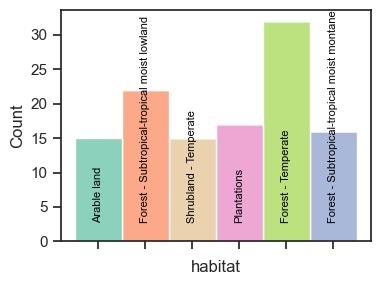

In [122]:
# Read the csv file with the data used for the correlation
df = pd.read_csv(os.path.join(
                            CONFIG['save_dir'], 
                            csv_filename),
                            sep=',')

# print the number of aggregated samples 
print(f'The number of aggregated samples is {df.shape[0]}')

""" ==========================================================
    remove habitat with count less than 5 Sampling effort
=============================================================="""
# remove habitat with less than 5 aggregated samples
df = df.groupby('habitat').filter(lambda x: len(x) >= 5)

# print the number of sites after removing the habitats with less than 5 aggregated samples
print(f'The number of sites after removing the habitats with less than 5 aggregated samples is {df.shape[0]}')

# plot the density of files for each habitat
fig, ax = plt.subplots(figsize=(4,3))
# display the histogram of the count per habitat and set the legend outside the plot
sns.histplot(df, x='habitat', hue='habitat', multiple='stack', palette=HABITAT_COLOR, ax=ax, legend=False)
# no xtick label
ax.set_xticklabels([])
# add the habitat in each vertical bar of the histogram
# change the police of the text to 8
for i, v in enumerate(df['habitat'].unique()):
    ax.text(i, 3, str(v), color='black', ha='center', fontsize= 8, rotation=90)

plt.show()


## 4. Regression with linear regression tools



How to interpret negative R² => mostly due to overfitting or problem of domain matching

Link : https://towardsdatascience.com/interpreting-r%C2%B2-a-narrative-guide-for-the-perplexed-086a9a69c1ec 

>  if we constrain ourselves to a narrower set of scenarios, namely linear models, and especially linear models estimated with least squares methods. Here, R² will behave as a proportion. In fact, it can be shown that, due to properties of least squares estimation, a linear model can never do worse than a model predicting the mean of the outcome variable. Which means, that a linear model can never have a negative R² — or at least, it cannot have a negative R² on the same data on which it was estimated (a debatable practice if you are interested in a generalizable model).

other link : https://towardsdatascience.com/explaining-negative-r-squared-17894ca26321

> While we can use any arbitrary model to generate the predictions for scoring, we need to realize that the aforementioned equality is defined for models trained on the same data. Therefore, it doesn’t necessarily hold true when we use test data to evaluate models built on train data! There is no guarantee that the differences between a foreign model’s predictions and the data is smaller than the variation within the data itself.

> To summarize, we should expect R² to be bounded between zero and one only if a linear regression model is fit, and it is evaluated on the same data it is fitted on. Else, the definition of R² can lead to negative values.
> For this reason, MAE and RMSE are more informative. CCC (concordance correlation coefficient) is also a good metric to  evaluate the precision and agreement between predicted and observed values


### 4.1 Select and init the regressor

In [123]:
"""****************************************************************************
# -------------------   Regressor  --------------------------
****************************************************************************"""

""" Huber Regressor"""
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py
# Best Regressor when outliers are present in x and y
model = HuberRegressor(max_iter=100, alpha=0.0001, epsilon=1.20, fit_intercept=False, warm_start=False, tol=1e-05)
print('Huber Regressor')


Huber Regressor


## 4.2 With a single indice

In [124]:
"""------------------------------------------------------------------------------
    Do the kfold regression
----------------------------------------------------------------------------"""

# Compute the metrics for each indice in order to find the best indice

# do not show the error in this cell
warnings.filterwarnings('ignore')

df_metrics_kfold = pd.DataFrame(columns=[
                                'INDICE', 
                                'CCC', 'CCC_L_SHIFT', 'CCC_S_SHIFT', 'CCC_BIAS', 
                                'ME',
                                'MAE', 'RMSE', 'R2', 'MEDIAN_AE', 
                                'pvalue'])

best_models_kfolds = {}

# Do Group Kfold Regression
for CURRENT_INDICE in CONFIG['list_indices'] :
    current_df_metrics_kfold, current_model_list = groupkfold_regression(
                                                        indices=[CURRENT_INDICE],
                                                        gt=GT,
                                                        df=df,
                                                        model=model,
                                                        seed = CONFIG['seed'],
                                                        verbose=False, 
                                                        )
    # concatenate the dataframe
    df_metrics_kfold = pd.concat([df_metrics_kfold, current_df_metrics_kfold], axis=0, ignore_index=True) 

    # cadd model to the dictionnary for the current indice
    best_models_kfolds.update(current_model_list[0])

# do not show the error in this cell
warnings.filterwarnings('default')

# sort the dataframe by R_CCC_train
df_metrics_kfold.sort_values(['CCC'], ascending=False, inplace=True)

# display the dataframe
pd.options.display.float_format = "{:,.2f}".format # display numbers with 2 decimals
display(df_metrics_kfold)

# interpretation of the scores
# CCC           => CCC is close to 1 when variables are very similar
# CCC_L_SHIFT   => the shift location of equivalent variables is close to 0
# CCC_S_SHIFT   => The scale shift of equivalent variables is close to 1
# CCC_BIAS      => bias correction factor measures the deviation of the regression line of the variables from the line with equation y=x. It is close to 1 when there is no deviation.
# ME            => ME close to 0 means no biais
# MAE           => MAE close to 0 means no error
# RMSE          => RMSE close to 0 means no error
# R2 
# MEDIAN_AE     => MEDIAN_AE close to 0 means no error
# pvalue

,INDICE,CCC,CCC_L_SHIFT,CCC_S_SHIFT,CCC_BIAS,ME,MAE,RMSE,R2,MEDIAN_AE,pvalue
58,nROI,0.53,-0.22,0.97,0.76,0.31,0.92,1.08,-0.44,0.93,0.01
20,NP,0.36,-0.22,0.91,0.73,0.01,1.06,1.30,-1.78,0.91,0.01
29,EPS,0.33,-0.80,0.68,0.58,0.27,1.22,1.39,-2.49,1.25,0.01
37,BIO,0.32,-0.85,0.94,0.59,0.47,1.38,1.57,-3.49,1.33,0.01
27,ECU,0.31,-0.52,0.58,0.63,0.08,1.08,1.25,-2.07,1.02,0.01
49,EVNspCount,0.30,-0.41,1.17,0.74,0.37,1.25,1.46,-1.25,1.10,0.01
28,ECV,0.27,-0.58,0.61,0.58,0.07,1.17,1.37,-2.32,1.14,0.02
47,EVNspFract,0.24,-0.62,1.26,0.61,0.52,1.48,1.72,-2.13,1.43,0.01
59,aROI,0.19,-1.30,1.17,0.35,0.89,2.23,2.48,-5.04,2.48,0.01
42,MFC,0.17,-0.36,0.38,0.30,0.03,1.28,1.49,-1.53,1.22,0.01


In [125]:
"""------------------------------------------------------------------------
    Find the R², MAE, Bias and p-value of the best model for each indice
-------------------------------------------------------------------------"""

# sort the column habitat to have the same automatic color assignation
df = df.sort_values(by='habitat')

df_r2 = pd.DataFrame(columns=['INDICE', 'R2', 'MAE', 'RMSE', 'ME', 'MEDIAN_AE', 'SE', 'p-value'])

for CURRENT_INDICE in CONFIG['list_indices'] :
    ###### Statistics to estimate the error in the data/model
    # Set the variables
    x = df[CURRENT_INDICE].values
    y = df[GT].values

    # Get the prediction from the best model
    y_model = (best_models_kfolds[CURRENT_INDICE].coef_[0])*x

    # Estimates of Error in Data/Model
    residual = y - y_model      # residuals; diff. actual data from predicted values

    # calculate the coefficient of determination 
    r2 = 1-np.sum(residual**2) / np.sum((y - np.mean(y))**2)

    # calculate the standard error of the regression coefficient
    SE = np.sqrt(np.sum(residual**2) / (len(y)-2)) / np.sqrt(np.sum((x - np.mean(x))**2))

    # calculate the mean absolute error
    mae = np.mean(np.abs(residual))

    # calculate the root mean square error
    rmse = np.sqrt(np.mean(residual**2))

    # calculate the mean error
    me = np.mean(residual)

    # calculate the median absolute error
    median_ae = np.median(np.abs(residual))

    # p-value of the regression based on the estimator and the standard error
    t = np.abs(best_models_kfolds[CURRENT_INDICE].coef_[0]) / SE
    # find the probability of the t-distribution
    pvalue = 2*(1-stats.t.cdf(t, df=len(y)-1))

    # add the metrics to the dataframe
    if df_r2.empty :
        df_r2 = pd.DataFrame({'INDICE': [CURRENT_INDICE], 'R2': [r2], 'MAE': [mae], 'RMSE': [rmse], 'ME': [me], 'MEDIAN_AE': [median_ae], 'SE': [SE], 'p-value': [pvalue]})
    else :
        df_r2 = pd.concat([df_r2, pd.DataFrame({'INDICE': [CURRENT_INDICE], 'R2': [r2], 'MAE': [mae], 'RMSE': [rmse], 'ME': [me], 'MEDIAN_AE': [median_ae], 'SE': [SE], 'p-value': [pvalue]})], ignore_index=True)

# sort the dataframe by R2
df_r2.sort_values(['R2'], ascending=False, inplace=True)
# display the dataframe
pd.options.display.float_format = "{:,.2f}".format # display numbers with 2 decimals
display(df_r2)

,INDICE,R2,MAE,RMSE,ME,MEDIAN_AE,SE,p-value
58,nROI,0.58,0.82,1.01,0.22,0.71,0.00,0.00
27,ECU,0.41,0.98,1.21,-0.07,0.88,1.47,0.00
29,EPS,0.38,1.03,1.24,0.30,0.92,2.44,0.00
20,NP,0.34,0.98,1.27,0.03,0.77,0.02,0.00
28,ECV,0.31,1.05,1.30,0.16,0.88,2.36,0.00
42,MFC,0.27,1.12,1.34,-0.09,1.00,4.89,0.00
48,EVNspMean,0.23,1.13,1.37,-0.01,1.09,19.18,0.00
44,ACTspFract,0.22,1.16,1.39,-0.03,1.12,10.77,0.01
45,ACTspCount,0.22,1.16,1.39,-0.03,1.12,0.00,0.01
46,ACTspMean,0.18,1.15,1.42,0.07,1.05,0.05,0.00


The slope of the best model is [0.03333811]
Statistics=0.979, p=0.067
Known dataset: Residual looks Gaussian (fail to reject H0)


/tmp/ipykernel_51126/3678564896.py:204: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "%s = %.2f" % (get_var_name(metric), metric),


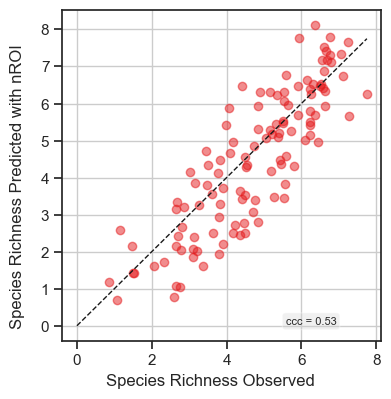

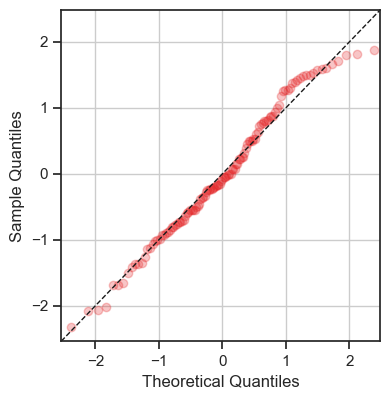

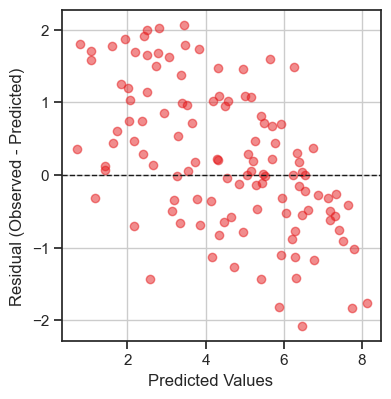

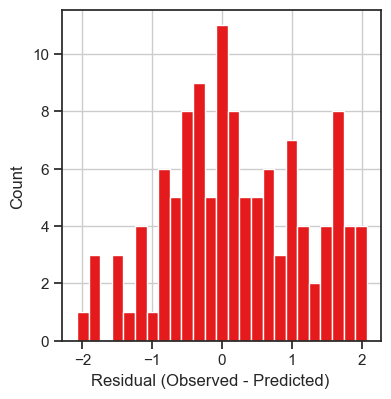

In [126]:
"""------------------------------------------------------------------------------
        Plot the prediction vs the test and the residuals for the best model
        for the selected indice
----------------------------------------------------------------------------"""

INDICE = 'nROI' # nROI NP EPS ECU BIO

# concatenate the list CONFIG['list_indices'] to a string
INDICE_STR = '_'.join([INDICE])

# with known dataset
X_kfold = df[INDICE].to_numpy().reshape(-1,1)
y_kfold = df[GT].astype('float')

# find the best model corresponding to the indice
best_model = best_models_kfolds[INDICE]

# print the coefficient of the best model
print(f'The slope of the best model is {best_model.coef_}')

# do the prediction
y_kfold_pred = best_model.predict(X_kfold)

# extract R_CCC_train from the dataframe (sometimes it's None when the fit is not possible)
ccc = df_metrics_kfold[df_metrics_kfold['INDICE']==INDICE_STR]['CCC']
if len(ccc) == 0 :
        ccc = 0

plot_datasets(
        y_kfold, 
        y_kfold_pred, 
        metric=ccc,
        xlabel='Species Richness Observed',
        ylabel='Species Richness Predicted with '+ ' '.join([INDICE]),
        color=RED,
        plot_qqplot=True,
        plot_residuals=True,
        plot_residuals_distribution=True)

# Test the normality of the residuals with shapiro test
# shapiro test
stat, p = stats.shapiro(y_kfold-y_kfold_pred)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
        print('Known dataset: Residual looks Gaussian (fail to reject H0)')
else:
        print('Known dataset: Residual does not look Gaussian (reject H0)')


r² is 0.58
mae is 0.82
bias is 0.22
p-value  is 0.00e+00
standard error of the regression S is 1.018294
The slope of the best model is 0.033 with a standard error of 0.002
prediction interval is  1.705122189187491


/tmp/ipykernel_51126/3453028920.py:99: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([], [], c=HABITAT_COLOR[habitat], label=habitat, marker='s', s=40)


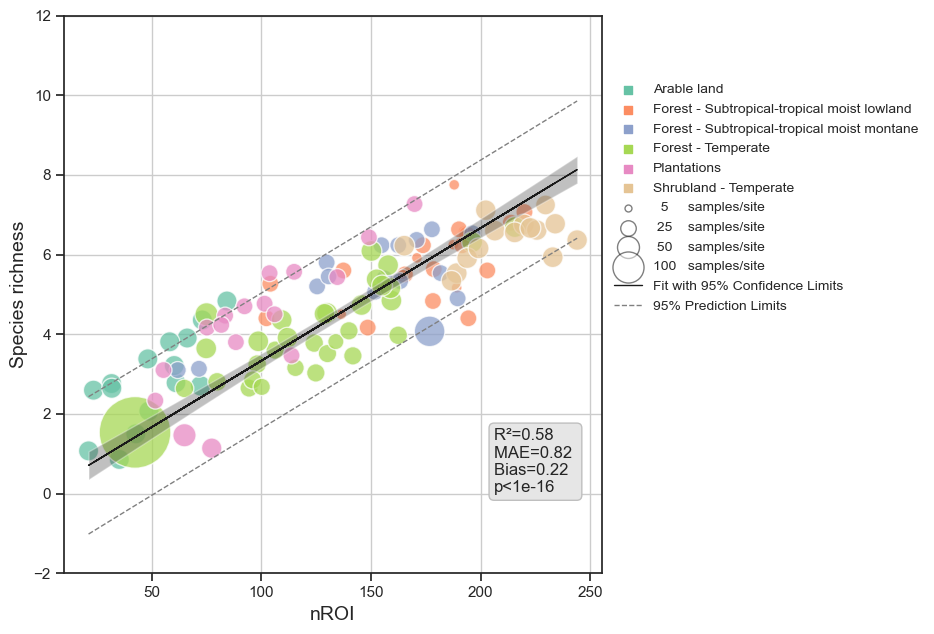

In [129]:
"""----------------------------------------------------------------
      Display correlation between the indice and the ground truth. 
-----------------------------------------------------------------"""

###### Statistics to estimate the error in the data/model
# sort the column habitat to have the same automatic color assignation
df = df.sort_values(by='habitat')

# Set the variables
x = df[INDICE].values
y = df[GT].values

# Get the prediction from the best model
y_model = (best_model.coef_[0])*x 

# Statistics
n     = df[INDICE].size                                     # number of observations
m     = 1                                                   # number of parameters
dof   = n - m                                               # degrees of freedom
t     = stats.t.ppf(0.95, dof)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
residual      = y - y_model                                      # residuals; diff. actual data from predicted values
chi2          = np.sum((residual / (y_model+0.01))**2)           # chi-squared; estimates error in data
chi2_red      = chi2 / dof                                       # reduced chi-squared; measures goodness of fit
S             = np.sqrt(np.sum(residual**2) / dof)               # standard error of the regression S also known as the standard error of the estimate
std_err_slope = np.sqrt(S**2 / (np.sum((x - np.mean(x))**2)))    # standard error of the slope

# calculate the coefficient of determination 
r2 = 1-np.sum(residual**2) / np.sum((y - np.mean(y))**2)
print(f'r² is {r2:.2f}')

# calculate the standard error of the regression coefficient
SE = np.sqrt(np.sum(residual**2) / (len(y)-2)) / np.sqrt(np.sum((x - np.mean(x))**2))

# estimate the MAE
mae = np.mean(np.abs(residual))
print(f'mae is {mae:.2f}')

# estimate the bias (= mean error (ME))
bias = np.mean(residual)
print(f'bias is {bias:.2f}')

# p-value of the regression based on the estimator and the standard error
pvalue = 2*(1-stats.t.cdf(np.abs(best_model.coef_[0]) / SE, df=dof))
print(f'p-value  is {pvalue:.2e}')

# standard error of the regression S 
print(f'standard error of the regression S is {S:.6f}')

# print the coefficient of the best model (with 3 decimals)
print(f'The slope of the best model is {best_model.coef_[0]:.3f} with a standard error of {std_err_slope:.3f}')


###### Display the correlation between the indice and the ground truth

# Display the correlation graphic between the indice and the ground truth
fig, ax1 = plt.subplots(1, 1)
ax1.grid()

# marker size
# extact the column count from df, and multiply the values (scalar) by 5
marker_size = df['count'].values*5

# display the scatterplot
sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.scatterplot(data=df, x=INDICE, y=GT, hue='habitat', palette=HABITAT_COLOR, alpha=0.75, s=marker_size, ax=ax1, legend=False)

# change y axis label
ax1.set_ylabel('Species richness', size=14)

# change x axis label
ax1.set_xlabel(INDICE, size=14)

# # set the y limit
ax1.set_ylim(-2, 12)

# add metrics on the graph
if pvalue >= 1e-16 :
      pvalue_str = 'p=%.2e' % pvalue
else:
      pvalue_str = 'p<1e-16'

ax1.annotate(
      "R²=%.2f \nMAE=%.2f \nBias=%.2f \n%s" % (r2, mae, bias, pvalue_str),      
      xy=(0.8, 0.2), 
      xycoords='axes fraction', 
      ha='left', 
      va='center', 
      bbox=dict(
            facecolor="0.9", 
            edgecolor='0.75', 
            boxstyle='round')
      )

# add a legend with fixed marker size for each habitat and its corresponding color
for habitat in df['habitat'].unique():
      ax1.scatter([], [], c=HABITAT_COLOR[habitat], label=habitat, marker='s', s=40)

# add bubble size legend
if 'species_richness_by_site_and_day' in csv_filename:
      bubble_sizes = [5, 15, 30, 60, 0]
      bubble_labels = [' 5     samples/day/site', '15    samples/day/site', '30    samples/day/site', '60    samples/day/site', '  ']
      for size, label in zip(bubble_sizes, bubble_labels):
            ax1.scatter([], [], c='white', edgecolor='black', alpha=0.5, s=size*5, label=label)
elif 'species_richness_by_site' in csv_filename:
      bubble_sizes = [5, 25, 50, 100]
      bubble_labels = ['  5     samples/site', ' 25    samples/site', ' 50    samples/site', '100   samples/site']
      for size, label in zip(bubble_sizes, bubble_labels):
            ax1.scatter([], [], c='white', edgecolor='black', alpha=0.5, s=size*5, label=label)

# plot the line of best fit
ax1.plot(x, y_model, "-", color='0.1', linewidth=1, alpha=1, label="Fit with 95% Confidence Limits")  

# Confidence Interval
x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = (best_model.coef_[0])*x2

# plot the confidence interval and the prediction interval on the graph
_, ci, pi = plot_pi_ci_manual(t, S, n, x, x2, y2, ax=ax1)
print("prediction interval is ", np.mean(pi))

# Move the legend to the bottom
ax1.legend(title="habitat", loc="upper left", fontsize=8)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 0.9), ncol=1, title=None, frameon=False, fontsize=10)

# Set figure size
fig.set_size_inches((9.5,6.5))
fig.tight_layout()

if INDICE == 'nROI' :
      # test if csv_filename contains species_richness_by_site_and_day
      if 'species_richness_by_site_and_day' in csv_filename :
            if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_1c.png'), dpi = 300, bbox_inches = "tight")
      elif 'species_richness_by_site' in csv_filename:
            if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_5.png'), dpi = 300, bbox_inches = "tight")
if INDICE == 'NP' :
      if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_4a.png'), dpi = 300, bbox_inches = "tight")
if INDICE == 'EPS' :
      if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_4b.png'), dpi = 300, bbox_inches = "tight")
if INDICE == 'ECU' :
      if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_4c.png'), dpi = 300, bbox_inches = "tight")

### 3.2 Regresssion with multiple indices

In [97]:
# list of indices for the regresssion with multiple indices
list_indices_without_corr = CONFIG['list_indices_multiple_regression']

# remove list_indices_to_remove in CONFIG['list_indices']
list_indices_to_remove= [x for x in CONFIG['list_indices'] if x not in list_indices_without_corr]

# print the list of indices
print(list_indices_without_corr)
print(list_indices_to_remove)

['NDSI', 'H', 'ECU', 'SNRf', 'ACI', 'LFC', 'TFSD', 'nROI', 'NP', 'BIO', 'ACTspMean', 'MEANf']
['ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'M', 'Ht', 'ACTtFraction', 'ACTtCount', 'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'VARf', 'SKEWf', 'KURTf', 'LEQf', 'BGNf', 'Hf', 'EAS', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'rBA', 'AnthroEnergy', 'BioEnergy', 'ROU', 'ADI', 'AEI', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'H_Havrda', 'H_Renyi', 'H_pairedShannon', 'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'aROI']


In [98]:
#############################################
# Do the kfold regression
#############################################

# do not show the error in this cell
warnings.filterwarnings("ignore")

# Normalize the data as now there are 60 indices
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[CONFIG['list_indices'] + [GT]] = scaler.fit_transform(df_scaled[CONFIG['list_indices'] + [GT]]) 

df_metrics_kfold, models_list = groupkfold_regression(
                                indices=list_indices_without_corr,
                                gt=GT,
                                df=df_scaled,
                                model=model,
                                seed = CONFIG['seed'],
                                verbose=True,
                            )   

warnings.filterwarnings('default')


The groups are [0 1 2 3 4 5 6]
CCC=0.65 CCC_L_SHIFT=-0.15 CCC_S_SHIFT=0.9 CCC_BIAS=0.88 ME0.05 MAE=0.38 RMSE=0.47 R2=0.07 MEDIAN_AE=0.32 P-value=0.009900990099009901


In [99]:
#############################################
# display the metrics
#############################################

pd.options.display.float_format = "{:,.2f}".format # display numbers with 2 decimals
df_metrics_kfold.sort_values(['CCC'], ascending=False, inplace=True)   
display(df_metrics_kfold.head(2))

,INDICE,CCC,CCC_L_SHIFT,CCC_S_SHIFT,CCC_BIAS,ME,MAE,RMSE,R2,MEDIAN_AE,pvalue
0,NDSI_H_ECU_SNRf_ACI_LFC_TFSD_nROI_NP_BIO_ACTsp...,0.65,-0.15,0.90,0.88,0.05,0.38,0.47,0.07,0.32,0.01


r² is 0.81
Statistics=0.994, p=0.239
Known dataset: Residual looks Gaussian (fail to reject H0)


/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HuberRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_51126/3678564896.py:204: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "%s = %.2f" % (get_var_name(metric), metric),


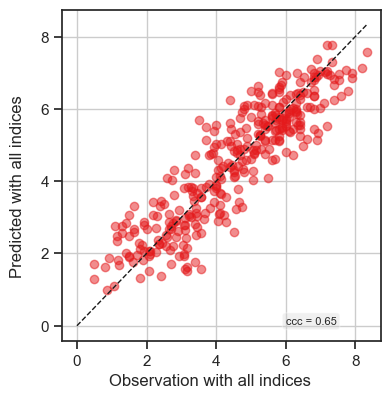

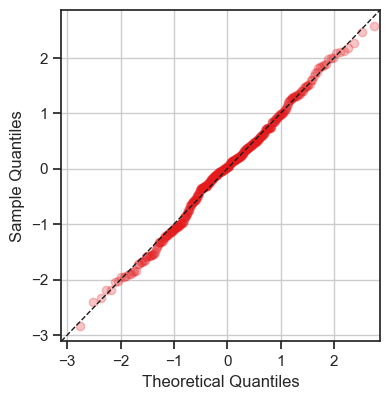

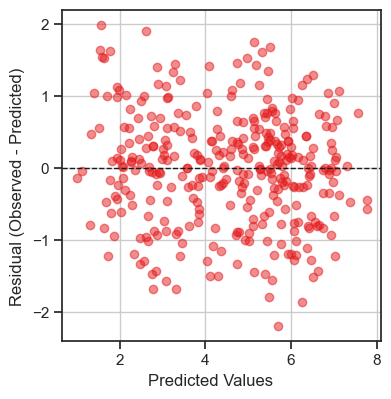

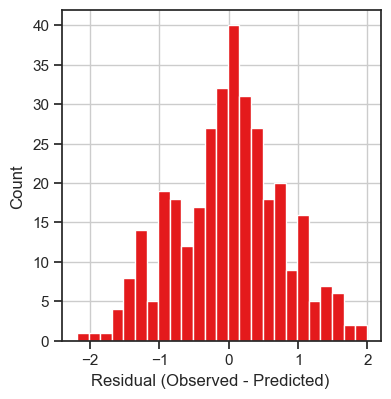

In [100]:
#############################################
# Plot the prediction vs the test
#############################################

# feature_names = CONFIG['list_indices']
feature_names = list_indices_without_corr

# concatenate the list CONFIG['list_indices'] to a string
INDICE_STR = '_'.join(feature_names)

# with known dataset
X_kfold = df_scaled[CONFIG['list_indices']].astype('float')
y_kfold = df_scaled[GT].astype('float')

# find the first value of the dictionnary models_list
best_model = models_list[0]
# get the key of the dictionnary
indice = list(best_model.keys())[0]  
# get the value of the dictionnary
best_model = best_model[indice]

# do the prediction
y_kfold_pred = best_model.predict(X_kfold[feature_names])

# inverse normalize
X_kfold[GT] = y_kfold
y_kfold = scaler.inverse_transform(X_kfold)[:,-1]
X_kfold[GT] = y_kfold_pred
y_kfold_pred = scaler.inverse_transform(X_kfold)[:,-1]

# metric
ccc = df_metrics_kfold[df_metrics_kfold['INDICE']==INDICE_STR]['CCC']

# Estimates of Error in Data/Model
residual = y_kfold - y_kfold_pred      # residuals; diff. actual data from predicted values

# calculate the coefficient of determination 
r2 = 1-np.sum(residual**2) / np.sum((y - np.mean(y))**2)
print(f'r² is {r2:.2f}')

# plot the prediction vs the test
plot_datasets(
        y_true=y_kfold, 
        y_pred=y_kfold_pred, 
        metric=ccc,
        xlabel='Observation with all indices',
        ylabel='Predicted with all indices',
        color=RED,
        plot_qqplot=True,
        plot_residuals=True,
        plot_residuals_distribution=True)

# Test the normality of the residuals with shapiro test
# shapiro test
stat, p = stats.shapiro(y_kfold-y_kfold_pred)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
        print('Known dataset: Residual looks Gaussian (fail to reject H0)')
else:
        print('Known dataset: Residual does not look Gaussian (reject H0)')

#### find coefficient importance



https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

In [101]:
# with known dataset
X_kfold = df_scaled[feature_names].astype('float')
y_kfold = df_scaled[GT].astype('float')

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=CONFIG['seed'])
cv_model = cross_validate(
    best_model,
    X_kfold,
    y_kfold,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

# initialize an empty dataframe to store the coefficients of the model
coefs = np.empty((len(feature_names)))

for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_kfold, y_kfold)) :
    coef_corrected = est.coef_ * X_kfold.iloc[train_idx].std(axis=0)
    # add the coefficients of the model to the dataframe
    coefs = np.vstack((coefs, coef_corrected))

# remove the first row
coefs = coefs[1:,:]

df_coef = pd.DataFrame(coefs, columns=feature_names)

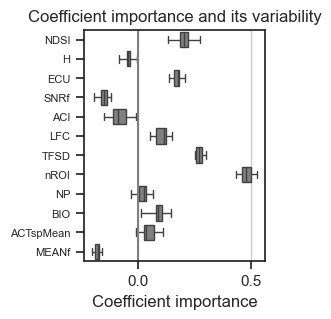

In [102]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3,3)
fig.tight_layout()
ax.grid()
sns.boxplot(data=df_coef, orient="h", color="grey", saturation=0.1, whis=10)
# add grid
ax.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.yticks(fontsize=8)
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)


/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)
/home/haupert/miniconda3/envs/ear-ml/lib/python3.10/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)


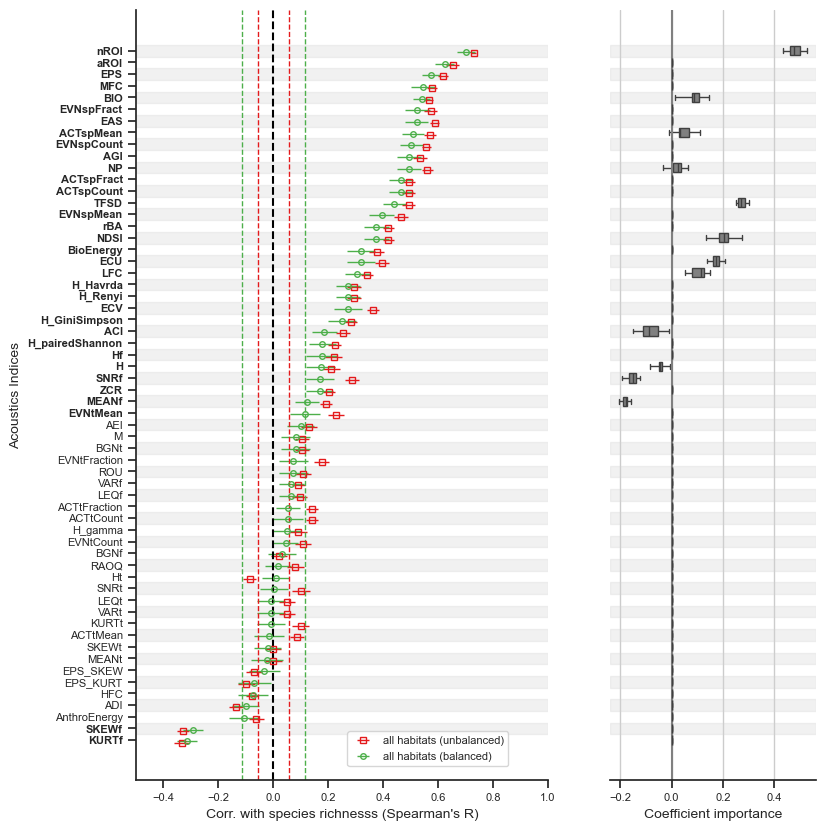

In [103]:
df_stat = pd.read_csv(os.path.join(CONFIG['save_dir'], GT+'_'+CONFIG['correlation_method']+"_r_sans_clip.csv"), sep=',', index_col=None)

# sort by r obtained with balanced dataset by habitats
sort_indices = df_stat[df_stat['habitat']=='all_balanced'].sort_values(by='r', ascending=False)['indice']

# Create an empty dictionary to store the mapping
indice_mapping = {}

# Iterate over the unique values of 'indice' and assign corresponding numbers
i = 0
for unique_indice in sort_indices:
    indice_mapping[unique_indice] = i
    i += 1

# Add the dictionary to the DataFrame
df_stat['indice_number'] = df_stat['indice'].map(indice_mapping)

# Generating labels and index
label = sort_indices
y = np.arange(len(label))

# select the indices with r > r_threshold for each habitat, dataset
df_all_balanced = df_stat[(df_stat['habitat']=='all_balanced')]
df_all_unbalanced = df_stat[(df_stat['habitat']=='all_unbalanced')]

# Apply the function to the 'list_column' and store the result in a new column
err_balanced = df_all_balanced['r'] - df_all_balanced['lower_bound_ci']
err_unbalanced =  df_all_unbalanced['r'] - df_all_unbalanced['lower_bound_ci']

sns.set_style("ticks")

# set 2 plots with shared y-axis but different size in x direction

fig, [ax1,ax2] = plt.subplots(1,2, width_ratios=(1,0.5), figsize=(8,10), sharey=True)

ax1.errorbar(x = df_all_unbalanced['r'], 
            y = df_all_unbalanced['indice_number'] + 0.2, 
            xerr=err_unbalanced, 
            label = 'all habitats (unbalanced)',
            marker='s', markersize = 4, markerfacecolor='none',
            linestyle="none", linewidth=1, color=RED, ecolor=RED)
ax1.errorbar(x = df_all_balanced['r'], 
            y = df_all_balanced['indice_number'] + 0.1, 
            xerr=err_balanced, 
            label = 'all habitats (balanced)',
            marker='o', markersize = 4, markerfacecolor='none',
            linestyle="none", linewidth=1, color=GREEN, ecolor=GREEN)

if format(CONFIG['correlation_method']) == 'pearson' :
    CORR_PLOT = 'Pearson'
elif format(CONFIG['correlation_method']) == 'spearman' :
    CORR_PLOT = 'Spearman'
elif format(CONFIG['correlation_method']) == 'kendall' :
    CORR_PLOT = 'Kendall'


ax1.set_xlabel('Corr. with species richnesss ({}\'s R)'.format(CORR_PLOT), fontsize=10)
ax1.set_ylabel('Acoustics Indices', fontsize=10)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.tick_params(axis='both', labelsize=8)

# Draw a vertical line at 0
ax1.axvline(x=0, color='black', linestyle='dashed')
ax1.axvline(x=df_stat[df_stat['habitat']=='all_unbalanced']['r_threshold'].unique(), color=RED, linestyle='dashed',linewidth=1)
ax1.axvline(x=df_stat[df_stat['habitat']=='all_balanced']['r_threshold'].unique(), color=GREEN, linestyle='dashed',linewidth=1)
ax1.axvline(x=-df_stat[df_stat['habitat']=='all_unbalanced']['r_threshold'].unique(), color=RED, linestyle='dashed',linewidth=1)
ax1.axvline(x=-df_stat[df_stat['habitat']=='all_balanced']['r_threshold'].unique(), color=GREEN, linestyle='dashed',linewidth=1)

# Reset y-ticks
ax1.set_yticks(y)
# Setting y-axis tick labels
ax1.set_yticklabels(label)

# Get axis labels on ax1
yticklabels = ax1.get_yticklabels()

# # Loop through labels and set font weight
for label in yticklabels:
    sub_df_stat = df_stat[df_stat['indice']==label.get_text()]

    # test if r is higher than r_threshold for habitat = 'all_balanced' and habitat = 'all_unbalanced'
    r_threshold_all_balanced = sub_df_stat[sub_df_stat['habitat'] == 'all_balanced']['r_threshold'].values[0]
    r_all_balanced = sub_df_stat[sub_df_stat['habitat'] == 'all_balanced']['r'].values[0]
    r_threshold_all_unbalanced = sub_df_stat[sub_df_stat['habitat'] == 'all_unbalanced']['r_threshold'].values[0]
    r_all_unbalanced = sub_df_stat[sub_df_stat['habitat'] == 'all_unbalanced']['r'].values[0]
    
    if ((abs(r_all_balanced)) > (abs(r_threshold_all_balanced))) and (abs((r_all_unbalanced)) > abs((r_threshold_all_unbalanced))) :
        label.set_fontweight('bold')

# Get the tick positions
y_ticks = ax1.get_yticks()
# Get the interval
y_delta = y_ticks[1] - y_ticks[0]
# Change background color every two ticks
for i in range(0, len(y_ticks), 2):
    ax1.axhspan(y_ticks[i]- y_delta/ 2, y_ticks[i] + y_delta/ 2, color='lightgrey', alpha=0.3)

# Set the x-axis limits
ax1.set_xlim(-0.5, 1)
# Create the legend and place it at the bottom of the figure
ax1.legend(loc='upper left', bbox_to_anchor=(0.5, 0.07), fontsize=8)

"""
    Second graph
"""
df_coef[list_indices_to_remove] = 0
# order columns of df_coef following sort_indices
df_coef = df_coef[sort_indices]

# add grid
ax2.grid()
# sns.stripplot(data=df_coef, orient="h", palette="dark:k", alpha=0.25)
sns.boxplot(data=df_coef, orient="h", color="grey", saturation=0.1, whis=10, ax=ax2)
# add grid
ax2.axvline(x=0, color=".5")
# remove external lines around the graph
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
# change the size of the ticks
ax2.tick_params(axis='x', labelsize=8)

# Get the tick positions in y axis
y_ticks = ax2.get_yticks()
# Get the interval
y_delta = y_ticks[1] - y_ticks[0]
# Change background color every two ticks
for i in range(0, len(y_ticks), 2):
    ax2.axhspan(y_ticks[i]- y_delta/ 2, y_ticks[i] + y_delta/ 2, color='lightgrey', alpha=0.3)

# remove ticks on the vertical axis y on the axis ax2
ax2.tick_params(axis='y', color='white')

plt.xlabel("Coefficient importance", fontsize=10)
plt.subplots_adjust(left=0.05)

plt.show()


if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_1a_b.png'), dpi = 300, bbox_inches = "tight")